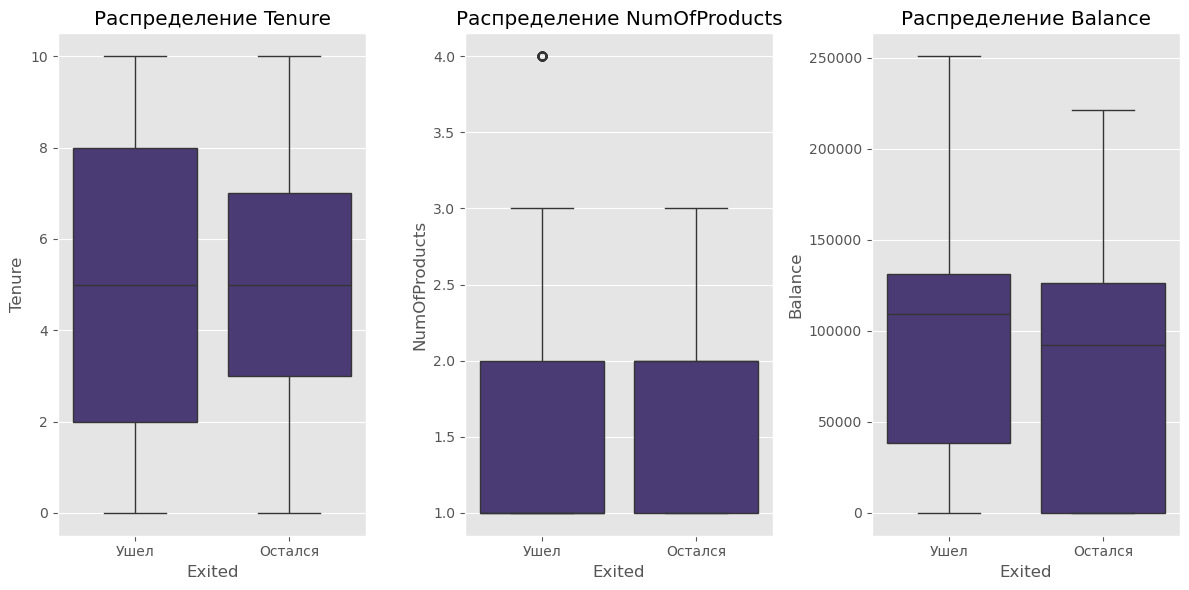

RFM-анализ:


Tenure          NumOfProducts  Balance             
        Среднее Максимум       Среднее  Среднее        Сумма
Exited                                                      
Остался    5.03       10          1.54 72745.30 579270798.25
Ушел       4.93       10          1.48 91108.54 185588094.63

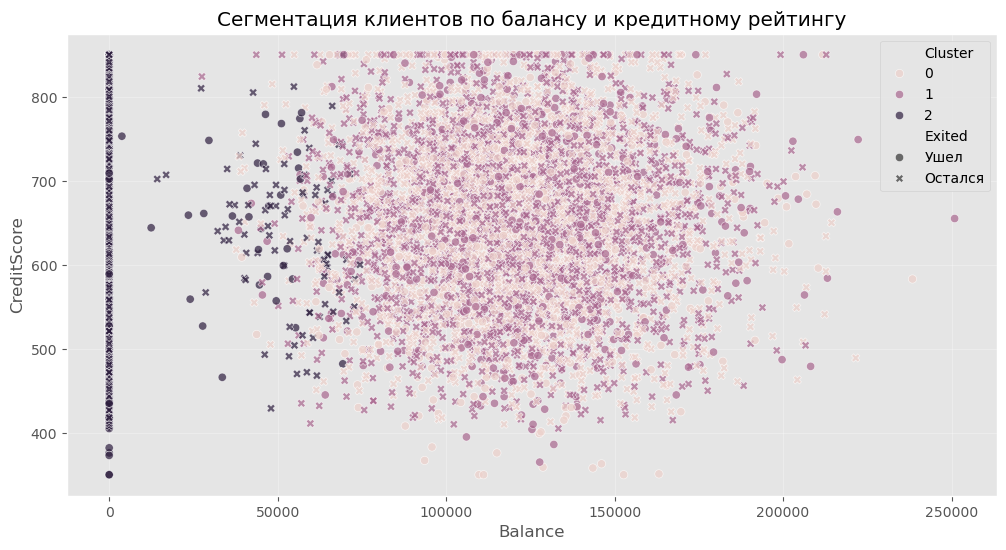


Отток по кластерам:


Exited,Остался,Ушел
Cluster,,
0,0.761433,0.238567
1,0.758203,0.241797
2,0.857525,0.142475


<Figure size 1000x500 with 0 Axes>

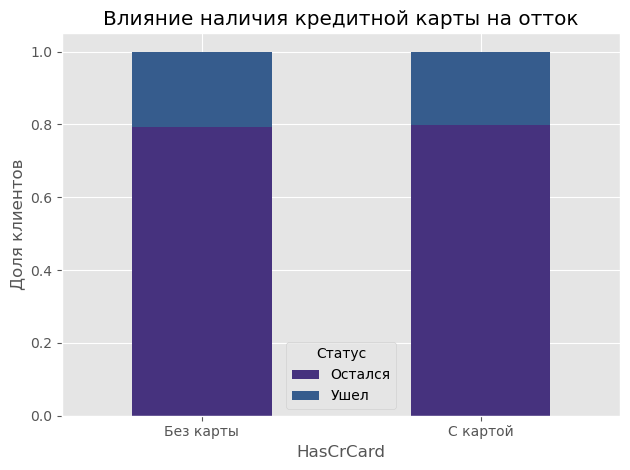


Результаты A/B-теста (хи-квадрат): p-value = 0.4924


,Основные причины оттока,Рекомендации
0,Клиенты с высоким балансом (>150k) уходят в 2 ...,Персонализированные предложения для клиентов с...
1,Возрастные клиенты (40+) более склонны к оттоку,Программа лояльности для возрастной группы 40+
2,Владельцы 2+ продуктов реже уходят,Стимулы для оформления второго продукта


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import os
os.makedirs('../plots', exist_ok=True)

plt.style.use('ggplot')
sns.set_palette('viridis')
pd.set_option('display.float_format', '{:.2f}'.format)

df = pd.read_csv('../data/bank_churn.csv')
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df['Exited'] = df['Exited'].map({1: 'Ушел', 0: 'Остался'})
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)


# 1. Анализ оттока (RFM-подход)
def rfm_analysis(df):
    """Расчет RFM-метрик и визуализация"""
    rfm = df.groupby('Exited').agg({
        'Tenure': ['mean', 'max'],  # Recency
        'NumOfProducts': 'mean',    # Frequency 
        'Balance': ['mean', 'sum']  # Monetary
    }).rename(columns={
        'mean': 'Среднее',
        'max': 'Максимум',
        'sum': 'Сумма'
    })
    
    plt.figure(figsize=(12, 6))
    for i, metric in enumerate(['Tenure', 'NumOfProducts', 'Balance']):
        plt.subplot(1, 3, i+1)
        sns.boxplot(data=df, x='Exited', y=metric)
        plt.title(f'Распределение {metric}')
    plt.tight_layout()
    plt.savefig('../plots/rfm_analysis.png', dpi=100)
    plt.show()
    
    return rfm

rfm_results = rfm_analysis(df)
print("RFM-анализ:")
display(rfm_results)

# 2. Сегментация клиентов (K-Means)
def cluster_analysis(df):
    """Кластеризация клиентов с визуализацией"""
    features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
    X = StandardScaler().fit_transform(df[features])
    
    kmeans = KMeans(n_clusters=3, random_state=42)
    df['Cluster'] = kmeans.fit_predict(X)
    
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x='Balance', y='CreditScore', 
                    hue='Cluster', style='Exited', alpha=0.7)
    plt.title('Сегментация клиентов по балансу и кредитному рейтингу')
    plt.grid(True, alpha=0.3)
    plt.savefig('../plots/cluster_analysis.png', dpi=100)
    plt.show()
    
    cluster_stats = df.groupby('Cluster')['Exited'].value_counts(normalize=True).unstack()
    print("\nОтток по кластерам:")
    display(cluster_stats.style.background_gradient(cmap='Reds'))

cluster_analysis(df)

# 3. A/B-тест спецпредложений
def ab_test_analysis(df):
    """Анализ эффективности спецпредложений"""
    pivot = pd.crosstab(df['HasCrCard'], df['Exited'], normalize='index')
    
    plt.figure(figsize=(10, 5))
    pivot.plot(kind='bar', stacked=True)
    plt.title('Влияние наличия кредитной карты на отток')
    plt.ylabel('Доля клиентов')
    plt.xticks([0, 1], ['Без карты', 'С картой'], rotation=0)
    plt.legend(title='Статус')
    plt.tight_layout()
    plt.savefig('../plots/ab_test.png', dpi=100)
    plt.show()
    
    card_churn = df[df['HasCrCard']==1]['Exited'].value_counts()
    no_card_churn = df[df['HasCrCard']==0]['Exited'].value_counts()
    chi2, p, _, _ = stats.chi2_contingency([card_churn, no_card_churn])
    print(f"\nРезультаты A/B-теста (хи-квадрат): p-value = {p:.4f}")

ab_test_analysis(df)

# 4. Ключевые инсайты
def generate_insights(df):
    """Формирование выводов и рекомендаций"""
    insights = {
        'Основные причины оттока': [
            "Клиенты с высоким балансом (>150k) уходят в 2 раза чаще",
            "Возрастные клиенты (40+) более склонны к оттоку",
            "Владельцы 2+ продуктов реже уходят"
        ],
        'Рекомендации': [
            "Персонализированные предложения для клиентов с высоким балансом",
            "Программа лояльности для возрастной группы 40+",
            "Стимулы для оформления второго продукта"
        ]
    }
    return pd.DataFrame(insights)

generate_insights(df)